In [1]:
import itertools as it
import json
import re
import warnings

import dexplot as dxp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
import seaborn as sns
from dfpvizpy.dfpvizpy import dfpSave
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

import plotting_functions as pf

# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)

%matplotlib inline
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None
sns.set(style="ticks", context="talk")
sns.set_palette("colorblind")

In [2]:
# this is the .json file with all of the questions and coding of the variables
with open("../raw_data/dfp_survey_questions.json", "r") as fp:
    polling_info = json.load(fp)

In [132]:
other_cols = set(polling_info["misc"]["other_cols"])
quant_cols = set(polling_info["misc"]["quant_cols"])
unknown_cols = set(polling_info["misc"]["unknown_cols"])
agree_order = polling_info["misc"]["agree_order"]
age_order = polling_info["misc"]["age_order"]
net_positivity_dict = polling_info["misc"]["net_positivity_dict"]
state_dict = polling_info["misc"]["state_dict"]
state_nums_dict = polling_info["state"]
dict_keys = set(polling_info.keys())
agree_numbs = polling_info["misc"]["agree_numbs"]


support_dict = {
    "Neither support nor oppose": "Neutral",
    "Somewhat oppose": "Oppose",
    "Somewhat support": "Support",
    "Strongly oppose": "Oppose",
    "Strongly support": "Support",
}

In [4]:
# reading in the data to a dataframe
df = pd.read_csv("../raw_data/DFP_WTHH_release.csv", index_col=0)

# there are two values that need to be moved into the "employ" column
df.loc[2939]["employ"] = 6
df.loc[3110]["employ"] = 9
df.drop(columns="job", inplace=True)
# df.fillna('?', inplace=True)
df["state"] = df["state"].replace("District of Columbia", 11)
df_cols = set(df.columns.tolist())
qual_cols = df_cols - quant_cols - other_cols - unknown_cols

In [5]:
# replace vlaues in qualative answers
for column in qual_cols:
    df[column] = (
        df[column]
        .fillna(999)
        .astype(int)
        .astype(str)
        .replace("999", "?")
        .replace(polling_info[column])
    )
quant_df = df[list(quant_cols)].astype(float)
qual_df = df[list(qual_cols)]
qual_df["weights"] = quant_df.weight_DFP

In [6]:
# # saving counts to a text file
# with open("../raw_data/polling_counts.txt", "w") as f:
#     for column in qual_cols:
#         f.write(column + " | " + polling_info[column]["question"] + "\n\n")
#         f.write("*-" * 35 + "\n\n")
#         f.write(qual_df[column].value_counts().to_string())
#         f.write("\n\n\n")

In [7]:
# for col in qual_cols:
#     s = sns.catplot(
#         x="age5",
#         kind="count",
#         hue=col,
#         col="gender",
#         data=df,
#         col_wrap=2,
#         height=6,
#         aspect=2,
#         legend=False,
#         order=list(polling_info["age5"].values())[:-1],
#     )
#     s.ax.set_ylabel("Number of Respondents")
#     s.ax.set_xlabel("Age")
#     s.ax.set_title(polling_info["FLAG"]["question"])
#     s.axes[1].legend(frameon=False)
#     s.axes[0].set_title("Female")
#     s.axes[1].set_title("Male")
#     # s.fig.tight_layout()
#     s.fig.suptitle(polling_info[col]["question"].title())
#     s.fig.subplots_adjust(top=0.8)
#     dfpSave(f"../figures/age_and_{col}.png", s.axes)
# #     plt.show()

In [9]:
qual_df["counts"] = 1

In [177]:
qual_df.columns.tolist()

['PATH',
 'SOCIALDOMINANCE_SUPERIOR',
 'campaign_contact_mailer',
 'SOURCES_10',
 'SYSTEM',
 'pew_churatd',
 'MARREP',
 'CUSTOMS',
 'SOCIALDOMINANCE_NOTPUSH',
 'hispanic',
 'favor_mcconnell',
 'favor_labor',
 'educ2',
 'union_combined_5',
 'pp18_votelikely',
 'RACE_IDENT',
 'FLAG',
 'FAVORS',
 'pp18_polactions_7',
 'SOURCES_4',
 'EMOTIONS_12',
 'VOTE_GEN',
 'BOND',
 'pid7_oths',
 'race3',
 'race2',
 'EMOTIONS_3',
 'pp18_polactions_3',
 'SOURCES_11',
 'favor_rep',
 'SOURCES_7',
 'INTELLIGENT_Blacks',
 'djtrelct',
 'dtrpsupp',
 'SOCIALDOMINANCE_EQUALIDEAL',
 'DESERVE_rich',
 'PUBLICINT',
 'VOTECONF',
 'EMOTIONS_2',
 'REMARKS',
 'educ',
 'campaign_contact_emails',
 'POLCORRECT',
 'NONVOTE_WHY_5',
 'SOURCES_1',
 'OFFEND',
 'pp18_polactions_2',
 'campaign_contact_socialmedia',
 'EMOTIONS_10',
 'SOURCES_17',
 'NONVOTE_WHY_4',
 'EMOTIONS_4',
 'pid7_reps',
 'SOURCES_16',
 'JOBS',
 'DEPORT',
 'marstat',
 'union_combined_2',
 'FREECOLL',
 'specsenvote18_undecided',
 'NONVOTE_WHY_2',
 'EMPATHY',


In [172]:
def freq_pivot(data, xx, vals="weights", col=None, hue=None, rows=None):
    """
    
    """
    if col is not None and hue is None:
        pvt_df = data[[xx, col, vals]]

        drp_index = pvt_df[(pvt_df[xx] == "?") | (pvt_df[col] == "?")].index

        pvt_df.drop(drp_index, inplace=True)

        pvt = pvt_df.pivot_table(
            vals, index=[xx, col], aggfunc=sum, fill_value=0, margins=False
        )

        pvt_percent = np.round(pvt.div(pvt.sum(axis=1), axis=0) * 100, decimals=2)

        df_percent = pvt_percent.stack().reset_index()
        df_percent.columns = [xx, col, "Percentage"]

        return (pvt_percent, df_percent)

    if col is None and hue is not None:
        pvt_df = data[[xx, hue, vals]]

        drp_index = pvt_df[(pvt_df[xx] == "?") | (pvt_df[hue] == "?")].index

        pvt_df.drop(drp_index, inplace=True)

        pvt = pvt_df.pivot_table(
            vals, index=xx, columns=[hue], aggfunc=sum, fill_value=0, margins=False
        )

        pvt_percent = np.round(pvt.div(pvt.sum(axis=1), axis=0) * 100, decimals=2)

        df_percent = pvt_percent.stack().reset_index()
        df_percent.columns = [xx, hue, "Percentage"]

        return (pvt_percent, df_percent)

    if col is None and hue is None:

        pvt_df = data[[xx, vals]]
        drp_index = pvt_df[(pvt_df[xx] == "?")].index

        pvt_df.drop(drp_index, inplace=True)

        pvt = pvt_df.pivot_table(
            vals, index=xx, aggfunc=sum, fill_value=0, margins=False
        )
        pvt_percent = np.round(
            pvt.div(pvt.sum(axis=0).values, axis=1) * 100, decimals=2
        )
        pvt_percent.columns = ["Percentage"]

        return (pvt_percent, pvt_percent)

    else:
        pvt_df = data[[xx, col, hue, vals, rows]]

        drp_index = pvt_df[
            (pvt_df[xx] == "?")
            | (pvt_df[hue] == "?")
            | (pvt_df[col] == "?")
            | (pvt_df[rows] == "?")
        ].index

        pvt_df.drop(drp_index, inplace=True)

        pvt = pvt_df.pivot_table(
            vals,
            index=[xx, col, rows],
            columns=[hue],
            aggfunc=sum,
            fill_value=0,
            margins=False,
        )

        pvt_percent = np.round(pvt.div(pvt.sum(axis=1), axis=0) * 100, decimals=2)

        df_percent = pvt_percent.stack().reset_index()
        df_percent.columns = [xx, col, rows, hue, "Percentage"]

        return (pvt_percent, df_percent)

In [178]:
hue = "M4A"
xx = "age5"
col = "gender"
vals = "weights"
row = "FLAG"

pvt_percent, df_percent = freq_pivot(qual_df, xx, hue=hue, col=col, rows=row)

df_percent
# df_percent.reset_index(inplace=True)

# df_percent[col].replace(support_dict, inplace=True)
# df_percent.pivot_table(index=col, aggfunc=sum).plot(kind='barh')

age5  gender                           FLAG                         M4A  \
0    18-29  Female                     Don't know  Neither support nor oppose   
1    18-29  Female                     Don't know                    Not sure   
2    18-29  Female                     Don't know             Somewhat oppose   
3    18-29  Female                     Don't know            Somewhat support   
4    18-29  Female                     Don't know             Strongly oppose   
5    18-29  Female                     Don't know            Strongly support   
6    18-29  Female    Slavery and White Supremacy  Neither support nor oppose   
7    18-29  Female    Slavery and White Supremacy                    Not sure   
8    18-29  Female    Slavery and White Supremacy             Somewhat oppose   
9    18-29  Female    Slavery and White Supremacy            Somewhat support   
10   18-29  Female    Slavery and White Supremacy             Strongly oppose   
11   18-29  Female    Slavery and White Supremacy            Strongly support   
12   18-29  Female  Southern Heritage and Culture  Neither support nor oppose   
13   18-29  Female  Southern Heritage and Culture                    Not sure   
14   18-29  Female  Southern Heritage and Culture             Somewhat oppose   
15   18-29  Female  Southern Heritage and Culture            Somewhat support   
16   18-29  Female  Southern Heritage and Culture             Strongly oppose   
17   18-29  Female  Southern Heritage and Culture            Strongly support   
18   18-29    Male                     Don't know  Neither support nor oppose   
19   18-29    Male                     Don't know                    Not sure   
20   18-29    Male                     Don't know             Somewhat oppose   
21   18-29    Male                     Don't know            Somewhat support   
22   18-29    Male                     Don't know             Strongly oppose   
23   18-29    Male                     Don't know            Strongly support   
24   18-29    Male    Slavery and White Supremacy  Neither support nor oppose   
25   18-29    Male    Slavery and White Supremacy                    Not sure   
26   18-29    Male    Slavery and White Supremacy             Somewhat oppose   
27   18-29    Male    Slavery and White Supremacy            Somewhat support   
28   18-29    Male    Slavery and White Supremacy             Strongly oppose   
29   18-29    Male    Slavery and White Supremacy            Strongly support   
..     ...     ...                            ...                         ...   
150    65+  Female    Slavery and White Supremacy  Neither support nor oppose   
151    65+  Female    Slavery and White Supremacy                    Not sure   
152    65+  Female    Slavery and White Supremacy             Somewhat oppose   
153    65+  Female    Slavery and White Supremacy            Somewhat support   
154    65+  Female    Slavery and White Supremacy             Strongly oppose   
155    65+  Female    Slavery and White Supremacy            Strongly support   
156    65+  Female  Southern Heritage and Culture  Neither support nor oppose   
157    65+  Female  Southern Heritage and Culture                    Not sure   
158    65+  Female  Southern Heritage and Culture             Somewhat oppose   
159    65+  Female  Southern Heritage and Culture            Somewhat support   
160    65+  Female  Southern Heritage and Culture             Strongly oppose   
161    65+  Female  Southern Heritage and Culture            Strongly support   
162    65+    Male                     Don't know  Neither support nor oppose   
163    65+    Male                     Don't know                    Not sure   
164    65+    Male                     Don't know             Somewhat oppose   
165    65+    Male                     Don't know            Somewhat support   
166    65+    Male                     Don't know             Strongly oppose   
167    65+    Male                   

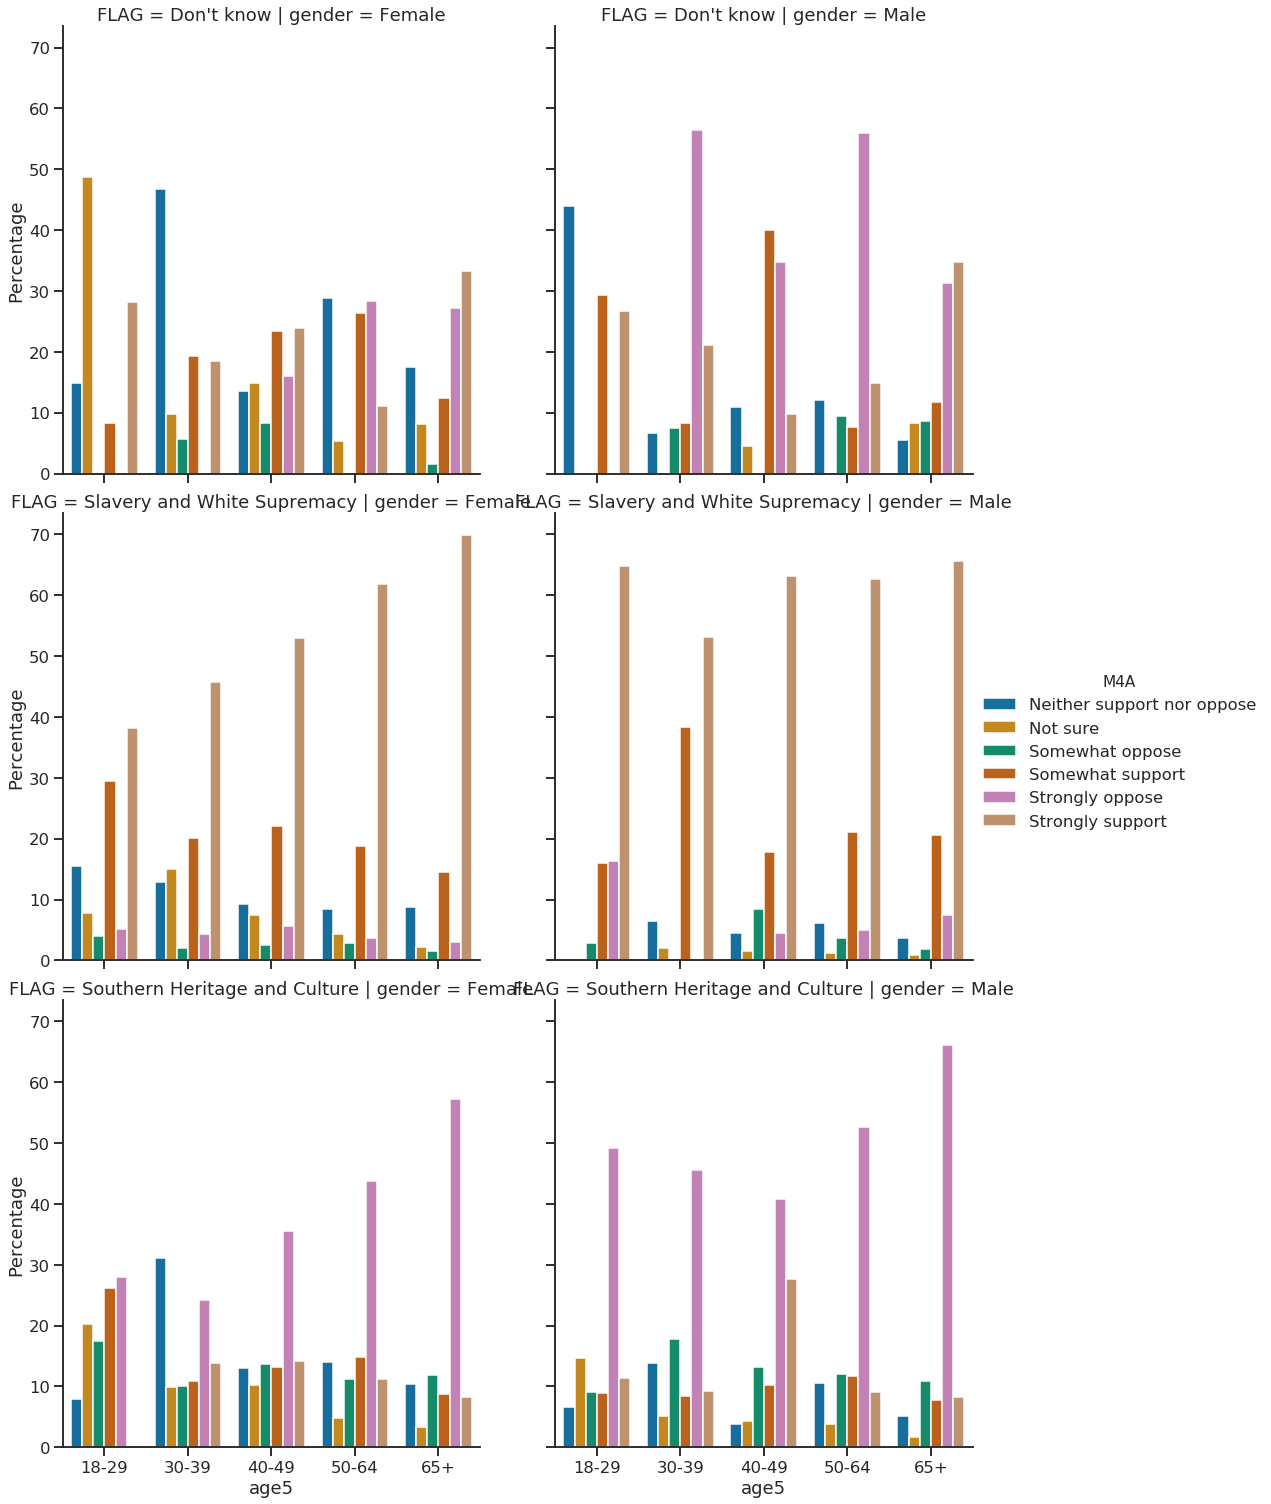

In [179]:
s = sns.catplot(
    x=xx,
    y="Percentage",
    hue=hue,
    row=row,
    col=col,
    data=df_percent,
    kind="bar",
    height=7,
    legend=True,
)

In [171]:
data = qual_df
pvt_df = data[[xx, col, hue, row, vals]]

drp_index = pvt_df[
    (pvt_df[xx] == "?")
    | (pvt_df[hue] == "?")
    | (pvt_df[col] == "?")
    | (pvt_df[row] == "?")
].index

pvt_df.drop(drp_index, inplace=True)

pvt = pvt_df.pivot_table(
    vals, index=[row, xx, col], columns=[hue], aggfunc=sum, fill_value=0, margins=False
)

pvt_percent = np.round(pvt.div(pvt.sum(axis=1), axis=0) * 100, decimals=2)
display(pvt_percent)
df_percent = pvt_percent.stack().reset_index()
display(df_percent)

M4A                                      Neither support nor oppose  Not sure  \
pid7                       age5  gender                                         
Independent                18-29 Female                        0.00     32.52   
                                 Male                         10.96     11.05   
                           30-39 Female                       25.53      0.00   
                                 Male                         21.67      0.00   
                           40-49 Female                       24.33      0.00   
                                 Male                          3.68     17.25   
                           50-64 Female                       12.67      5.04   
                                 Male                         11.98      5.29   
                           65+   Female                       29.24      2.94   
                                 Male                          5.48      3.58   
Lean Democrat              18-29 Female                       12.40     21.33   
                                 Male                          0.00      0.00   
                           30-39 Female                       17.28     19.90   
                                 Male                          0.00      6.60   
                           40-49 Female                        2.75      8.73   
                                 Male                          3.09      0.00   
                           50-64 Female                       10.38      1.59   
                                 Male                          9.31      0.00   
                           65+   Female                        0.00      1.83   
                                 Male                          2.55      0.72   
Lean Republican            18-29 Female                        0.00     16.34   
                                 Male                          0.00      0.00   
                           30-39 Female                       25.24      8.99   
                                 Male                          8.80     16.19   
                           40-49 Female                        6.88     12.46   
                                 Male                          9.36      3.55   
                           50-64 Female                        8.07      5.66   
                                 Male                          5.36      3.42   
                           65+   Female                        7.59      3.64   
                                 Male                          3.09      1.75   
...                                                             ...       ...   
Not very strong Republican 18-29 Female                       19.89     26.61   
                                 Male                          0.00      0.00   
                           30-39 Female                       42.20      8.14   
                                 Male                          0.00      0.00   
                           40-49 Female                       11.71     18.28   
                                 Male                          0.00      0.00   
                           50-64 Female                       15.96      7.69   
                                 Male                          7.23      7.03   
                           65+   Female                       11.09     12.60   
                                 Male                          4.54      2.99   
Strong Democrat            18-29 Female                        8.24      7.73   
                                 Male                          0.00      0.00   
                           30-39 Female                       13.74      6.50   
                                 Male                          7.06      0.00   
                           40-49 Female                       10.95      6.82   
                                 Male                          6.13      0.00   
                           50-6

pid7   age5  gender                         M4A      0
0          Independent  18-29  Female  Neither support nor oppose   0.00
1          Independent  18-29  Female                    Not sure  32.52
2          Independent  18-29  Female             Somewhat oppose   0.00
3          Independent  18-29  Female            Somewhat support  41.63
4          Independent  18-29  Female             Strongly oppose   0.00
5          Independent  18-29  Female            Strongly support  25.85
6          Independent  18-29    Male  Neither support nor oppose  10.96
7          Independent  18-29    Male                    Not sure  11.05
8          Independent  18-29    Male             Somewhat oppose   0.00
9          Independent  18-29    Male            Somewhat support   7.76
10         Independent  18-29    Male             Strongly oppose  24.26
11         Independent  18-29    Male            Strongly support  45.97
12         Independent  30-39  Female  Neither support nor oppose  25.53
13         Independent  30-39  Female                    Not sure   0.00
14         Independent  30-39  Female             Somewhat oppose  18.99
15         Independent  30-39  Female            Somewhat support  24.29
16         Independent  30-39  Female             Strongly oppose   8.36
17         Independent  30-39  Female            Strongly support  22.83
18         Independent  30-39    Male  Neither support nor oppose  21.67
19         Independent  30-39    Male                    Not sure   0.00
20         Independent  30-39    Male             Somewhat oppose   0.00
21         Independent  30-39    Male            Somewhat support  20.55
22         Independent  30-39    Male             Strongly oppose  49.86
23         Independent  30-39    Male            Strongly support   7.93
24         Independent  40-49  Female  Neither support nor oppose  24.33
25         Independent  40-49  Female                    Not sure   0.00
26         Independent  40-49  Female             Somewhat oppose  15.61
27         Independent  40-49  Female            Somewhat support  15.25
28         Independent  40-49  Female             Strongly oppose  26.86
29         Independent  40-49  Female            Strongly support  17.95
..                 ...    ...     ...                         ...    ...
432  Strong Republican  40-49    Male  Neither support nor oppose   0.00
433  Strong Republican  40-49    Male                    Not sure   0.00
434  Strong Republican  40-49    Male             Somewhat oppose  11.02
435  Strong Republican  40-49    Male            Somewhat support  13.45
436  Strong Republican  40-49    Male             Strongly oppose  50.49
437  Strong Republican  40-49    Male            Strongly support  25.04
438  Strong Republican  50-64  Female  Neither support nor oppose  12.35
439  Strong Republican  50-64  Female                    Not sure   3.51
440  Strong Republican  50-64  Female             Somewhat oppose  11.30
441  Strong Republican  50-64  Female            Somewhat support  12.89
442  Strong Republican  50-64  Female             Strongly oppose  56.63
443  Strong Republican  50-64  Female            Strongly support   3.32
444  Strong Republican  50-64    Male  Neither support nor oppose  13.32
445  Strong Republican  50-64    Male                    Not sure   1.00
446  Strong Republican  50-64    Male             Somewhat oppose  10.74
447  Strong Republican  50-64    Male            Somewhat support   9.28
448  Strong Republican  50-64    Male             Strongly oppose  56.85
449  Strong Republican  50-64    Male            Strongly support   8.81
450  Strong Republican    65+  Female  Neither support nor oppose   8.72
451  Strong Republican    65+  Female                    Not sure   1.97
452  Strong Republican    65+  Female             Somewhat oppose   9.43
453  Strong Republican    65+  Female            Somewhat support   6.64
454  Strong Republican    65+  Female             Strongly oppose  67.09
455

In [170]:
pvt

M4A                                      Neither support nor oppose  Not sure  \
pid7                       age5  gender                                         
Independent                18-29 Female                      0.0000    3.9306   
                                 Male                        2.8965    2.9218   
                           30-39 Female                      3.4636    0.0000   
                                 Male                        4.4626    0.0000   
                           40-49 Female                      5.0774    0.0000   
                                 Male                        1.1580    5.4207   
                           50-64 Female                      5.8370    2.3223   
                                 Male                        8.4923    3.7464   
                           65+   Female                      9.2706    0.9320   
                                 Male                        2.4734    1.6141   
Lean Democrat              18-29 Female                      3.2402    5.5716   
                                 Male                        0.0000    0.0000   
                           30-39 Female                      4.3047    4.9582   
                                 Male                        0.0000    2.0527   
                           40-49 Female                      0.7946    2.5265   
                                 Male                        1.2230    0.0000   
                           50-64 Female                      5.8585    0.8977   
                                 Male                        4.4014    0.0000   
                           65+   Female                      0.0000    0.7599   
                                 Male                        1.2348    0.3487   
Lean Republican            18-29 Female                      0.0000    1.2079   
                                 Male                        0.0000    0.0000   
                           30-39 Female                      5.7162    2.0364   
                                 Male                        1.5853    2.9185   
                           40-49 Female                      1.4469    2.6210   
                                 Male                        4.0561    1.5393   
                           50-64 Female                      4.5942    3.2214   
                                 Male                        3.7473    2.3942   
                           65+   Female                      4.7123    2.2602   
                                 Male                        2.6633    1.5137   
...                                                             ...       ...   
Not very strong Republican 18-29 Female                      2.4971    3.3402   
                                 Male                        0.0000    0.0000   
                           30-39 Female                      7.9962    1.5420   
                                 Male                        0.0000    0.0000   
                           40-49 Female                      2.5807    4.0292   
                                 Male                        0.0000    0.0000   
                           50-64 Female                      6.5751    3.1693   
                                 Male                        3.1022    3.0167   
                           65+   Female                      3.7973    4.3136   
                                 Male                        2.3236    1.5313   
Strong Democrat            18-29 Female                      4.4063    4.1329   
                                 Male                        0.0000    0.0000   
                           30-39 Female                      9.6833    4.5843   
                                 Male                        4.2354    0.0000   
                           40-49 Female                      9.1609    5.7068   
                                 Male                        3.0365    0.0000   
                           50-6

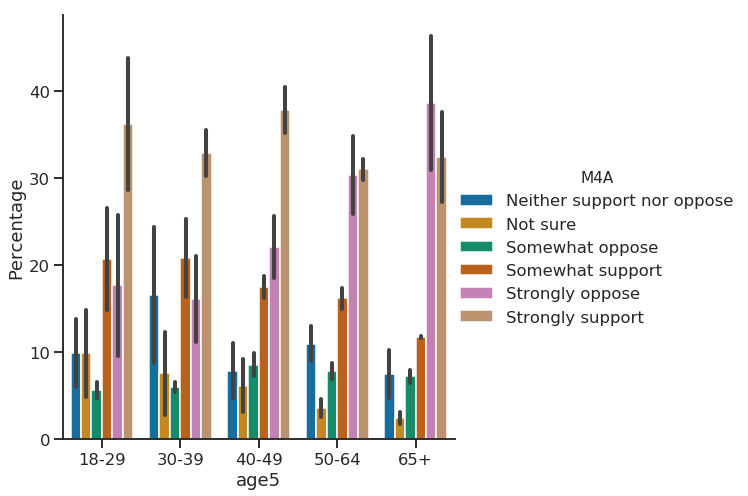

In [160]:
s = sns.catplot(
    x=xx,
    y="Percentage",
    hue=hue,
    data=df_percent,
    kind="bar",
    height=7,
    legend=True,
)

In [128]:
net_positivity_dict

{'Neither agree nor disagree': 'Neutral',
 'Somewhat agree': 'Positive',
 'Somewhat disagree': 'Negative',
 'Strongly agree': 'Positive',
 'Strongly disagree': 'Negative'}

In [71]:
pvt_percent

BORDER  Don't know  Neither support nor oppose  Somewhat oppose  \
age5                                                              
18-29         4.61                        9.51            11.05   
30-39         1.78                        9.33            11.91   
40-49         1.63                        7.30             7.45   
50-64         1.68                        6.15             8.08   
65+           0.31                        4.66             5.18   

BORDER  Somewhat support  Strongly oppose  Strongly support  
age5                                                         
18-29               7.56            45.75             21.52  
30-39              12.28            39.19             25.51  
40-49              12.02            39.83             31.77  
50-64               7.21            32.81             44.06  
65+                 7.75            35.14             46.96

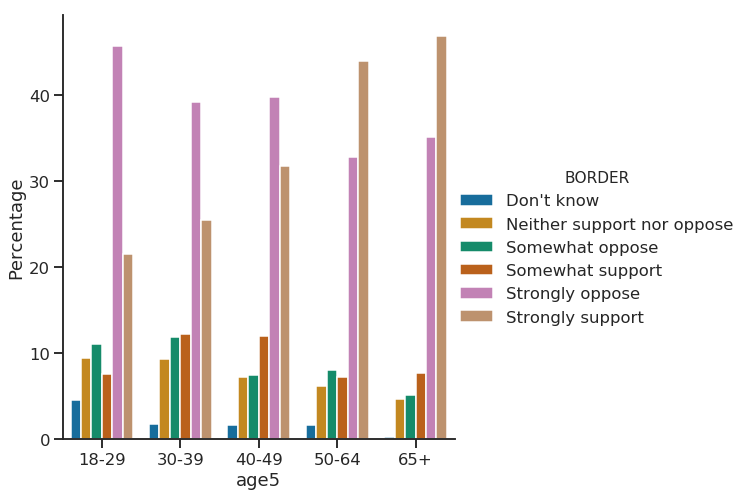

In [70]:
s = sns.catplot(
    x=xx,
    y="Percentage",
#     col=col,
    hue=hue,
    data=df_percent,
    kind="bar",
#     col_wrap=2,
#     col_order=df_percent[col].unique(),
    height=7,
    legend=True,
)

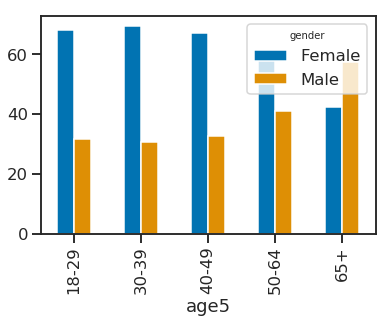

In [47]:
ag = qual_df.pivot_table("counts", index="age5", columns="gender", aggfunc=sum)
pag = np.round(100 * ag.div(ag.sum(axis=1), axis=0), decimals=2)
pag.plot(kind='bar')

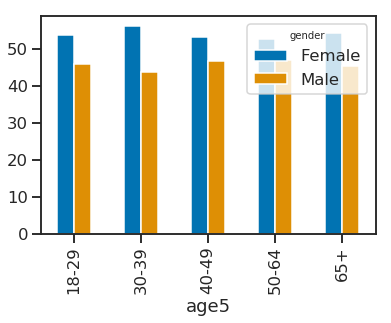

In [48]:
ag = qual_df.pivot_table("weights", index="age5", columns="gender", aggfunc=sum)
pag = np.round(100 * ag.div(ag.sum(axis=1), axis=0), decimals=2)
pag.plot(kind='bar')

In [17]:
hue = "BORDER"
freq_dfs, freq_tables = pf.freq_df(
    qual_df.age5, col=qual_df.gender, hue=qual_df[hue])

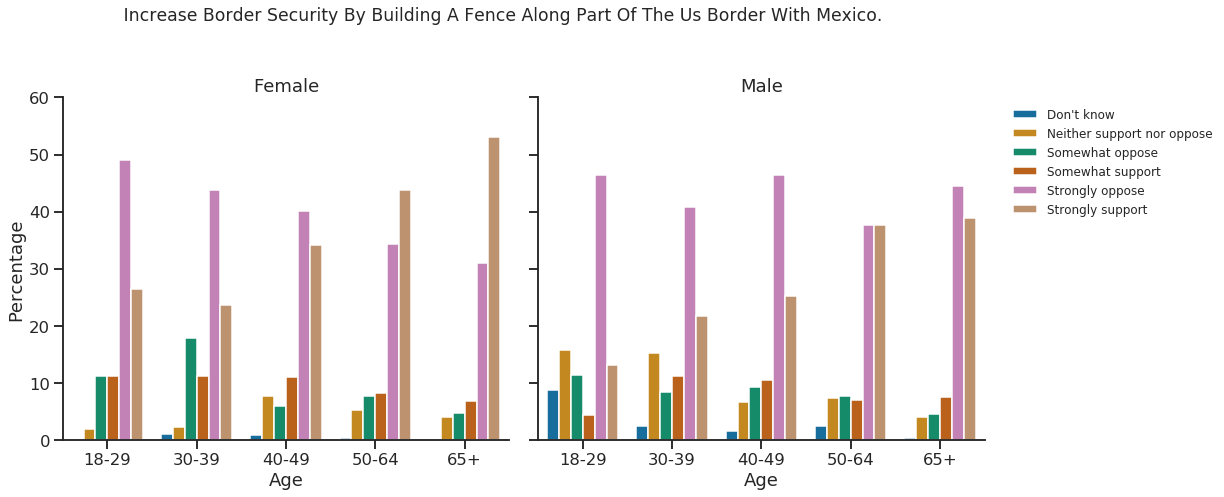

In [18]:
# freq_dfs[freq_dfs[hue].name + '_sort'] = freq_dfs[hue]
# freq_dfs[freq_dfs[hue].name + '_sort'].replace(agree_numbs, inplace=True)
# freq_dfs.sort_values(by=freq_dfs[hue].name + '_sort', inplace=True,
#                      ascending=False)
x_label = "Age"
leg_title = "Offending Remarks"
y_range = [0, 60]
col_names = qual_df.gender.unique()
s = sns.catplot(
    x="age5",
    y="Percentage",
    col="gender",
    hue=hue,
    data=freq_dfs,
    kind="bar",
    col_wrap=2,
    col_order=["Male", "Female"],
    height=7,
    legend=False,
)
for idx, ax in enumerate(s.axes):
    ax.set_xticklabels(age_order)
    ax.set_ylim(y_range)
    ax.set_title(col_names[idx])
    ax.set_xlabel(x_label)
# ax.legend(loc='upper right', frameon=False, fontsize='large')
ax.legend(frameon=False, fontsize="large",
          bbox_to_anchor=(1.04, 1), loc="upper left")
s.fig.suptitle(
    polling_info[hue]["question"].title().split(":")[-1], fontsize="xx-large"
)
s.fig.subplots_adjust(top=0.8)
# plt.show()
# s.figure.set_figheight(10)
# s.figure.set_figwidth(15)
# s.axes.tick_params(axis='x', rotation=45)
# s.axes.set_xlabel('')
# s.add_legend(label_order=agree_order, title='')
# s.fig.suptitle(hue); dfpSave(f'../figures/DFP_gender_age_{hue}.png', s.axes)
# s.savefig(f'../figures/gender_age_{hue}.png')

In [20]:
freq_dfs[hue].replace(net_positivity_dict, inplace=True)
freq_dfs[hue].replace(support_dict, inplace=True)

comb = []
for gender in freq_dfs.gender.unique():
    for age in freq_dfs.age5.unique():
        for position in freq_dfs[hue].unique():

            sm = freq_dfs[
                (freq_dfs.age5 == age)
                & (freq_dfs.gender == gender)
                & (freq_dfs[hue] == position)
            ]
            comb.append([gender, age, position, sm.Percentage.sum(axis=0)])
test_df = pd.DataFrame(comb, columns=["gender", "age5", hue, "Percentage"])
freq_dfs.sort_values(by="age5", inplace=True)

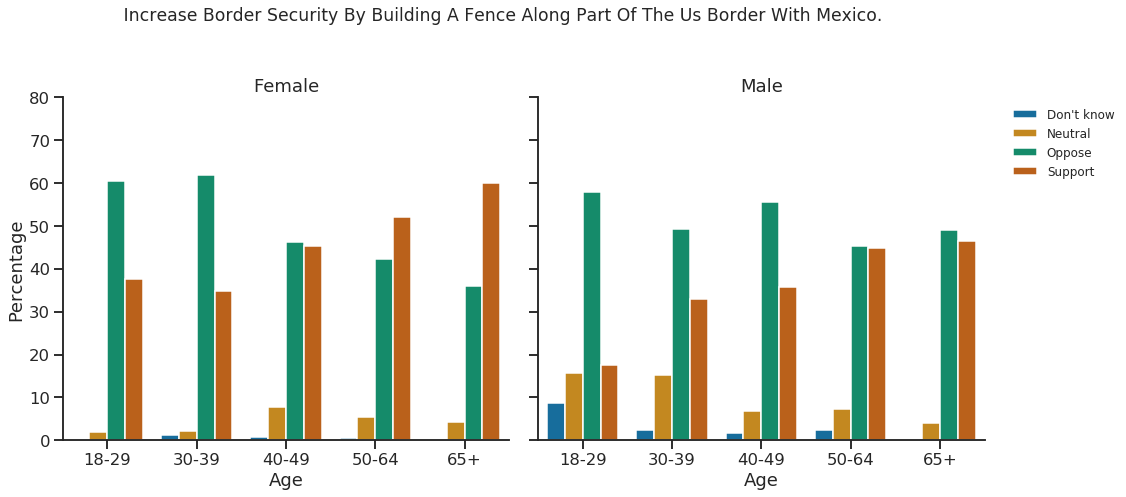

In [21]:
x_label = "Age"
leg_title = "Offending Remarks"
y_range = [0, 80]
col_names = qual_df.gender.unique()
s = sns.catplot(
    x="age5",
    y="Percentage",
    col="gender",
    hue=hue,
    data=test_df,
    kind="bar",
    col_wrap=2,
    col_order=["Male", "Female"],
    height=7,
    legend=False,
)
for idx, ax in enumerate(s.axes):
    ax.set_xticklabels(age_order)
    ax.set_ylim(y_range)
    ax.set_title(col_names[idx])
    ax.set_xlabel(x_label)
ax.legend(frameon=False, fontsize="large",
          bbox_to_anchor=(1.04, 1), loc="upper left")
s.fig.suptitle(
    polling_info[hue]["question"].title().split(":")[-1], fontsize="xx-large"
)
s.fig.subplots_adjust(top=0.8)

In [22]:
li = []
for age in freq_dfs.age5.unique():
    for gender in freq_dfs.gender.unique():
        sm = freq_dfs[(freq_dfs.age5 == age) & (freq_dfs.gender == gender)]
        #         li.append([
        #             age, gender, sm[sm.OFFEND == 'Positive']['Percentage'].values.sum() -
        #             sm[sm.OFFEND == 'Negative']['Percentage'].values.sum()
        #         ])
        li.append(
            [
                age,
                gender,
                sm[sm[hue] == "Support"]["Percentage"].values.sum()
                - sm[sm[hue] == "Oppose"]["Percentage"].values.sum(),
            ]
        )

In [23]:
dfc = pd.DataFrame(li, columns=["Age", "Gender", "Net Positivity"])
dfc

Age  Gender  Net Positivity
0  18-29  Female          -40.34
1  18-29    Male          -22.64
2  30-39  Female          -16.26
3  30-39    Male          -26.96
4  40-49  Female          -19.82
5  40-49    Male           -0.85
6  50-64  Female           -0.63
7  50-64    Male            9.82
8    65+  Female           -2.54
9    65+    Male           23.99

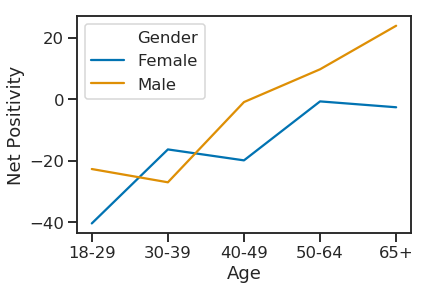

In [24]:
s = sns.lineplot(x="Age", y="Net Positivity", data=dfc, hue="Gender")

In [26]:
scl = [
    [0.0, "rgb(242,240,247)"],
    [0.2, "rgb(218,218,235)"],
    [0.4, "rgb(188,189,220)"],
    [0.6, "rgb(158,154,200)"],
    [0.8, "rgb(117,107,177)"],
    [1.0, "rgb(84,39,143)"],
]
df["text"] = df["state"]
df["z"] = df.FT_Blacks.replace("?", "0").astype(float) - 50
df["location"] = df.state.replace(state_nums_dict).replace(state_dict)

data = [
    dict(
        type="choropleth",
        colorscale="YIOrRd",
        autocolorscale=True,
        locations=df.location,
        z=df.z,
        locationmode="USA-states",
        text=df.text,
        marker=dict(line=dict(color="rgb(255,255,255)", width=2)),
        colorbar=dict(title="Trust"),
    )
]

layout = dict(
    title=polling_info["FT_Blacks"]["question"],
    geo=dict(
        scope="usa",
        projection=dict(type="albers usa"),
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
    ),
)

fig = dict(data=data, layout=layout)
iplot(fig, filename="../figures/d3-cloropleth-map.html")

In [30]:
top_labels = [
    "Strongly<br>agree",
    "Agree",
    "Neutral",
    "Disagree",
    "Strongly<br>disagree",
]

colors = [
    "rgba(38, 24, 74, 0.8)",
    "rgba(71, 58, 131, 0.8)",
    "rgba(122, 120, 168, 0.8)",
    "rgba(164, 163, 204, 0.85)",
    "rgba(190, 192, 213, 1)",
]

x_data = [
    [21, 30, 21, 16, 12],
    [24, 31, 19, 15, 11],
    [27, 26, 23, 11, 13],
    [29, 24, 15, 18, 14],
]

y_data = [
    "The course was effectively<br>organized",
    "The course developed my<br>abilities and skills " + "for<br>the subject",
    "The course developed " + "my<br>ability to think critically about<br>the subject",
    "I would recommend this<br>course to a friend",
]


traces = []

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        traces.append(
            go.Bar(
                x=[xd[i]],
                y=[yd],
                orientation="h",
                marker=dict(
                    color=colors[i], line=dict(color="rgb(248, 248, 249)", width=1)
                ),
            )
        )

layout = go.Layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1],
    ),
    yaxis=dict(showgrid=False, showline=False, showticklabels=False, zeroline=False),
    barmode="stack",
    paper_bgcolor="rgb(248, 248, 255)",
    plot_bgcolor="rgb(248, 248, 255)",
    margin=dict(l=120, r=10, t=140, b=80),
    showlegend=False,
)

annotations = []

for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(
        dict(
            xref="paper",
            yref="y",
            x=0.14,
            y=yd,
            xanchor="right",
            text=str(yd),
            font=dict(family="Arial", size=14, color="rgb(67, 67, 67)"),
            showarrow=False,
            align="right",
        )
    )
    # labeling the first percentage of each bar (x_axis)
    annotations.append(
        dict(
            xref="x",
            yref="y",
            x=xd[0] / 2,
            y=yd,
            text=str(xd[0]) + "%",
            font=dict(family="Arial", size=14, color="rgb(248, 248, 255)"),
            showarrow=False,
        )
    )
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(
            dict(
                xref="x",
                yref="paper",
                x=xd[0] / 2,
                y=1.1,
                text=top_labels[0],
                font=dict(family="Arial", size=14, color="rgb(67, 67, 67)"),
                showarrow=False,
            )
        )
    space = xd[0]
    for i in range(1, len(xd)):
        # labeling the rest of percentages for each bar (x_axis)
        annotations.append(
            dict(
                xref="x",
                yref="y",
                x=space + (xd[i] / 2),
                y=yd,
                text=str(xd[i]) + "%",
                font=dict(family="Arial", size=14, color="rgb(248, 248, 255)"),
                showarrow=False,
            )
        )
        # labeling the Likert scale
        if yd == y_data[-1]:
            annotations.append(
                dict(
                    xref="x",
                    yref="paper",
                    x=space + (xd[i] / 2),
                    y=1.1,
                    text=top_labels[i],
                    font=dict(family="Arial", size=14, color="rgb(67, 67, 67)"),
                    showarrow=False,
                )
            )
        space += xd[i]

layout["annotations"] = annotations

fig = go.Figure(data=traces, layout=layout)
iplot(fig, filename="../figures/bar-colorscale")

In [ ]:
'